DATALOADER

Compose(
    Resize(size=128, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(128, 128))
    ToTensor()
)
Classes: ['emptyBowl', 'emptyGlass', 'fullBowl', 'fullGlass']
Train Size: 560, Validation Size: 120, Test Size: 120


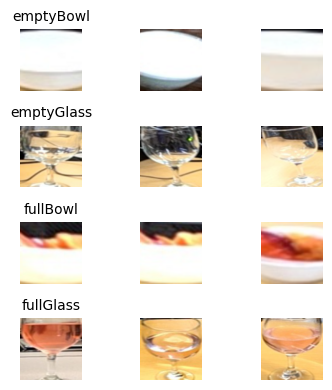

In [1]:
import torchvision.datasets as datasets
import torch.utils.data as data
import matplotlib.pyplot as plt

#choose folder
dataset_path = "imgs" 

from transform import *

dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
print(transform)
class_samples = {class_name: [] for class_name in dataset.classes}


train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = data.random_split(dataset, [train_size, val_size, test_size])

train_loader = data.DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=16, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

print("Classes:", dataset.classes)

import json
index_to_class = {i: name for i, name in enumerate(dataset.classes)}
with open('class_map.json', 'w') as f:
    json.dump(index_to_class, f)
    

print(f"Train Size: {len(train_dataset)}, Validation Size: {len(val_dataset)}, Test Size: {len(test_dataset)}")

for image, label in dataset:
    class_name = dataset.classes[label]
    if len(class_samples[class_name]) < 3: 
        class_samples[class_name].append(image)
    if all(len(samples) == 3 for samples in class_samples.values()): 
        break

fig, axes = plt.subplots(len(dataset.classes), 3, figsize=(4, len(dataset.classes)))
for i, (class_name, images) in enumerate(class_samples.items()):
    for j, image in enumerate(images):
        img = image.permute(1, 2, 0).numpy()  
        img = (img - img.min()) / (img.max() - img.min()) 
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        if j == 0:
            axes[i, j].set_title(class_name, fontsize=10)

plt.tight_layout()
plt.show()

In [2]:
from cnn import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(num_classes=len(dataset.classes)).to(device)
print(model)


CNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block4): Sequential(
  

TRAIN

In [3]:
import torch
import torch.optim as optim
import torch.nn as nn
import time

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1) 

def evaluate_accuracy(loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

def train_model(num_epochs=100):
    best_val_acc = 0.0
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_loss = running_loss / total
        train_acc = 100 * correct / total
        val_acc = evaluate_accuracy(val_loader)
        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc + 3:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "model.pth")
            print(f"Model saved at epoch {epoch+1} with Val Accuracy {val_acc:.2f}%")

    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time // 60:.0f}m {total_time % 60:.0f}s")
    print(f"Best validation accuracy: {best_val_acc:.2f}%")

train_model()


Epoch [1/100] | Loss: 1.0082 | Train Acc: 61.96% | Val Acc: 79.17%
Model saved at epoch 1 with Val Accuracy 79.17%
Epoch [2/100] | Loss: 0.5203 | Train Acc: 82.86% | Val Acc: 82.50%
Model saved at epoch 2 with Val Accuracy 82.50%
Epoch [3/100] | Loss: 0.4014 | Train Acc: 88.57% | Val Acc: 86.67%
Model saved at epoch 3 with Val Accuracy 86.67%
Epoch [4/100] | Loss: 0.3078 | Train Acc: 91.96% | Val Acc: 94.17%
Model saved at epoch 4 with Val Accuracy 94.17%
Epoch [5/100] | Loss: 0.2405 | Train Acc: 94.29% | Val Acc: 95.83%
Epoch [6/100] | Loss: 0.2057 | Train Acc: 95.54% | Val Acc: 95.83%
Epoch [7/100] | Loss: 0.1854 | Train Acc: 95.54% | Val Acc: 97.50%
Model saved at epoch 7 with Val Accuracy 97.50%
Epoch [8/100] | Loss: 0.1584 | Train Acc: 95.89% | Val Acc: 99.17%
Epoch [9/100] | Loss: 0.1371 | Train Acc: 97.68% | Val Acc: 98.33%
Epoch [10/100] | Loss: 0.1277 | Train Acc: 96.61% | Val Acc: 98.33%
Epoch [11/100] | Loss: 0.1175 | Train Acc: 97.86% | Val Acc: 97.50%
Epoch [12/100] | Loss

KeyboardInterrupt: 

In [4]:
from settings import *

#print(classes,"classes")

with open('class_map.json', 'r') as f:
    class_map = json.load(f)
print(class_map)


4 number of classes
{'0': 'emptyBowl', '1': 'emptyGlass', '2': 'fullBowl', '3': 'fullGlass'}


c:\Users\x\Documents\Gitea-Capstone\flask-server\settings.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth', map_location=dev

TEST

In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random


correct = 0
total = 0
misclassified = [] 
correctly_classified = []  


class_correct = {i: 0 for i in range(len(dataset.classes))}
class_total = {i: 0 for i in range(len(dataset.classes))}

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i].item()
            class_total[label] += 1
            if predicted[i] == label:
                class_correct[label] += 1
                correctly_classified.append((images[i], label, predicted[i].item()))
            else:
                misclassified.append((images[i], label, predicted[i].item()))

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")
    
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(dataset.classes):
    acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f"{class_name}: {acc:.2f}% ({class_correct[i]}/{class_total[i]})")


Test Accuracy: 93.33%

Per-Class Accuracy:
emptyBowl: 100.00% (27/27)
emptyGlass: 93.75% (30/32)
fullBowl: 96.55% (28/29)
fullGlass: 84.38% (27/32)
